In [ ]:
# Final Revision of Capstone Feature Engineering Process

In [ ]:
# Feature Engineering File Notes
# File Sequence #6

# input =
# A. Labeled and Preprocessed Training Data Fold
# (Seen and Unseen data within Fold 1)

# output =
# A. Sub-selected feature set sourced from Fold 1...
# ... containing ONLY best features

# General Notebook Notes:

# 1. Inputs to this notebook should not have NaN values...
# ... that should happen in an earlier preprocessing NB

# 2. This notebook should only be used on the Training Fold -- Fold 1



In [ ]:
# mount google drive
from google.colab import drive
# this resets all notebook objects
drive.flush_and_unmount()
# mount/remount
drive.mount('/content/drive')

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [ ]:
# library imports

# data handling
import pandas as pd
# file handling
import os
# calculations
import numpy as np
# counting
from collections import Counter
# visualizations
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
# Primary notebook objects:

# shared location =
shared_drive = r"/content/drive/MyDrive/Capstone_Docs_Shared"

# train filenames =
train_train = "train_fold_1.csv"
train_test = "test_fold_1.csv"

# assemble filepaths
train_train_path = os.path.join(shared_drive, train_train)
train_test_path = os.path.join(shared_drive, train_test)

# define threshold for too highly correlated:
corr_threshold = 0.90

In [ ]:
# import fold 1 -- training fold -- unseen data only

t_train_df = pd.read_csv(train_train_path)

# Check for null values before modeling

print("Total Null Vals in Fold 1 - Unseen Data")
print(t_train_df.isna().sum().sum())

# convert date to datetime after file read
t_train_df['Date'] = pd.to_datetime(t_train_df['Date'])


Total Null Vals in Fold 1 - Unseen Data
0


In [ ]:
# column check
print(t_train_df.columns)

Index(['Date', 'Ticker', 'Close', 'D_Return', 'W_Return', 'M_Return',
       'D_Return_Offset', 'W_Return_Offset', 'M_Return_Offset', 'D_2_Label',
       'W_2_Label', 'M_2_Label', 'D_3_Label', 'W_3_Label', 'M_3_Label',
       'D_5_Label', 'W_5_Label', 'M_5_Label', 'Open', 'High', 'Low', 'Volume',
       'UMCSENT', 'DGORDER', 'GDP', 'PCE', 'HOUST', 'RSXFS', 'ICSA', 'T10Y2Y',
       'PPIACO', 'ADXDNO', 'Year', 'SMA_5', 'SMA_10', 'SMA_20', 'SMA_50',
       'SMA_75', 'SMA_100', 'EMA_5', 'EMA_10', 'EMA_20', 'EMA_50', 'EMA_75',
       'EMA_100', 'RSI_5', 'RSI_7', 'RSI_9', 'RSI_14', 'RSI_21', 'RSI_30',
       'RSI_50', 'Bollinger_Mid_10', 'Bollinger_Upper_10',
       'Bollinger_Lower_10', 'Bollinger_Mid_14', 'Bollinger_Upper_14',
       'Bollinger_Lower_14', 'Bollinger_Mid_30', 'Bollinger_Upper_30',
       'Bollinger_Lower_30', 'Bollinger_Mid_50', 'Bollinger_Upper_50',
       'Bollinger_Lower_50', 'Bollinger_Mid_100', 'Bollinger_Upper_100',
       'Bollinger_Lower_100', 'Stoch_%K_5', 'Stoch_%

In [ ]:
# columns to exclude from correlation analysis=
excluded_columns = ['Date', 'Ticker', 'observation_date', 'D_2_Label', 'W_2_Label',
       'M_2_Label', 'D_3_Label', 'W_3_Label', 'M_3_Label', 'D_5_Label',
       'W_5_Label', 'M_5_Label','Open', 'High', 'Low', 'Close', 'Adj Close',
       'D_Return', 'W_Return', 'M_Return',]

# add offset columns to excluded list -- we know we want those as model vars
o_s_vars = [col for col in t_train_df.columns if col.endswith('_Offset')]

excluded_columns.extend(o_s_vars)

In [ ]:
# input date check:

print("TRAINING FOLD")
print("")
print("UNSEEN SET DATES:")

t_train_beg_date = t_train_df['Date'].min()
t_train_end_date = t_train_df['Date'].max()

print(t_train_beg_date)
print(t_train_end_date)
print("Total Num Train Days:")
num_days_inclusive = (t_train_end_date - t_train_beg_date).days + 1
print(num_days_inclusive)

TRAINING FOLD

UNSEEN SET DATES:
1992-06-01 00:00:00
1994-01-12 00:00:00
Total Num Train Days:
591


In [ ]:
# Function to identify highly correlated features in training set
def correlation_matrix(train_df, exc_cols, threshold):
  # input =
  # A. training df all features, unseen data
  # B. columns to exlude from correlation mxt
  # ... labels, dates, etc.
  # C. correlation threshold
  # ... define how much is too correlated

  # subsection of excluded columns = 'included columns'...
  # ... i.e. X_all_feats
  include_cols = [col for col in train_df.columns if col not in exc_cols]

  # X set with intended subsectioning
  X_all_feats = train_df[include_cols]

  # calculate correlation mtx:
  corr_mtx = X_all_feats.corr().abs()

  # check correlation matrix
  print("Total Input Columns Found: ")
  print(len(corr_mtx.columns))

  # only use upper triangle of corr_mtx to ease calculation pressure
  upper = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool_))

  # ID highly correlated column pairs and their scores:
  high_corr_pairs = []
  # initiate loop to ID pairs and scores, go pairwise across cols, rows:
  for col in upper.columns:
    for row in upper.index:
      corr_val = float(upper.loc[row, col])
      if corr_val > threshold:
        high_corr_pairs.append((row, col, corr_val))
  print("Total High-Correlation Pairs Found: ")
  print(len(high_corr_pairs))
  # NOW that pairings and scores have been ID'd...
  # ... we can remove them strategically!

  # ID highly correlated columns based on pairs
  high_corr_cols = [column for column in upper.columns if any(upper[column] > threshold)]
  print("Total High-Correlation Columns Found: ")
  print(len(high_corr_cols))

  return high_corr_pairs


In [ ]:
# function to determine which features to drop
def features_to_drop(corr_pairs):
  # 1. Count appearances in corr_pairs
  # 2. Remove feature which appears most from features
  # 3. Remove any pairs which contain feature
  # 4. Repeat until no pairs???
  # (4. -- Repeat until proj team subjectively satisfied with filtering)

  # list of all remaining pairs:
  remaining_pairs = corr_pairs.copy()

  # list of columns to drop:
  drop_cols = set()

  loop_counter = 0

  # initialize loop to track pairs
  # limit to 5 removals per run
  for i in range(5):
  #while remaining_pairs:
    loop_counter += 1
    # count freq of each feat in curr list of rem pairs:
    freq = Counter([feat for pair in remaining_pairs for feat in pair[:2]])
    # find most frequent
    worst_offender = freq.most_common(1)[0][0]

    # add worst offender to feat to drop list
    drop_cols.add(worst_offender)

    # remove worst offender from remaining pairs
    remaining_pairs = [pair for pair in remaining_pairs if worst_offender not in pair[:2]]

  drop_cols = list(drop_cols)
  print("Columns Dropped this Iteration:")
  print(drop_cols)
  return drop_cols



In [ ]:
# generate correlation matrix in training fold (Fold 1), unseen data
# (this step was executed to project team's satisfaction,...
# ... rather than to when there were 0 remaining correlated features...
# ... the cyclical nature of this code reflects that process)

t_train_testing_df = t_train_df.copy()

print("Original Number of Columns: ")
print(len(t_train_testing_df.columns))
# run correlation matrix removal processs for a first time
corr = correlation_matrix(t_train_testing_df, excluded_columns, corr_threshold)
drop_5_cols = features_to_drop(corr)
# drop cols
t_train_testing_df = t_train_testing_df.drop(columns=drop_5_cols)

# run correlation matrix for a second time
corr = correlation_matrix(t_train_testing_df, excluded_columns, corr_threshold)
drop_5_cols = features_to_drop(corr)
t_train_testing_df = t_train_testing_df.drop(columns=drop_5_cols)

# run correlation matrix for a third time
corr = correlation_matrix(t_train_testing_df, excluded_columns, corr_threshold)
drop_5_cols = features_to_drop(corr)
t_train_testing_df = t_train_testing_df.drop(columns=drop_5_cols)

# run correlation matrix for a fourth time
corr = correlation_matrix(t_train_testing_df, excluded_columns, corr_threshold)
drop_5_cols = features_to_drop(corr)
t_train_testing_df = t_train_testing_df.drop(columns=drop_5_cols)

# run correlation matrix for a fifth time
corr = correlation_matrix(t_train_testing_df, excluded_columns, corr_threshold)
drop_5_cols = features_to_drop(corr)
t_train_testing_df = t_train_testing_df.drop(columns=drop_5_cols)

# run correlation matrix for a sixth time
corr = correlation_matrix(t_train_testing_df, excluded_columns, corr_threshold)
drop_5_cols = features_to_drop(corr)
t_train_testing_df = t_train_testing_df.drop(columns=drop_5_cols)

print("Final Number of Columns: ")
print(len(t_train_testing_df.columns))

fin_cols = t_train_testing_df.columns
print(fin_cols)
print(len(fin_cols))

#corr = correlation_matrix(t_train_testing_df, excluded_columns, corr_threshold)
t_train_out = t_train_testing_df.copy()

#print(t_train_out)
print(len(t_train_out.columns))
print(t_train_out.columns)
#print(fin_cols)
print(len(fin_cols))

Original Number of Columns: 
88
Total Input Columns Found: 
62
Total High-Correlation Pairs Found: 
387
Total High-Correlation Columns Found: 
40
Columns Dropped this Iteration:
['SMA_50', 'Bollinger_Mid_30', 'EMA_75', 'SMA_75', 'EMA_50']
Total Input Columns Found: 
57
Total High-Correlation Pairs Found: 
257
Total High-Correlation Columns Found: 
35
Columns Dropped this Iteration:
['Bollinger_Upper_50', 'Bollinger_Lower_50', 'Bollinger_Lower_30', 'Bollinger_Upper_30', 'Bollinger_Mid_50']
Total Input Columns Found: 
52
Total High-Correlation Pairs Found: 
152
Total High-Correlation Columns Found: 
30
Columns Dropped this Iteration:
['Bollinger_Upper_10', 'SMA_20', 'Ichimoku_A', 'EMA_20', 'Bollinger_Mid_14']
Total Input Columns Found: 
47
Total High-Correlation Pairs Found: 
76
Total High-Correlation Columns Found: 
25
Columns Dropped this Iteration:
['SMA_10', 'Bollinger_Mid_10', 'EMA_10', 'Bollinger_Lower_14', 'Bollinger_Upper_14']
Total Input Columns Found: 
42
Total High-Correlation

In [ ]:
# examine remaining non-exclude features
filtered_feats = [feat for feat in t_train_out.columns if feat not in excluded_columns]
print(filtered_feats)
print(len(filtered_feats))

# full feature list
filtered_feats_full = [feat for feat in t_train_out.columns]
print(filtered_feats_full)
print(len(filtered_feats_full))

['Volume', 'UMCSENT', 'HOUST', 'RSXFS', 'ICSA', 'T10Y2Y', 'PPIACO', 'ADXDNO', 'Year', 'RSI_5', 'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'RSI_50', 'Bollinger_Lower_10', 'Bollinger_Upper_100', 'Bollinger_Lower_100', 'Stoch_%K_5', 'Stoch_%K_7', 'Stoch_%K_14', 'Stoch_%K_30', 'ADX_7', 'ADX_14', 'ADX_20', 'ADX_30', 'ADX_50', 'ROC_7', 'ROC_14', 'ROC_30', 'Williams_R_[14]', 'Ichimoku_B']
32
['Date', 'Ticker', 'Close', 'D_Return', 'W_Return', 'M_Return', 'D_Return_Offset', 'W_Return_Offset', 'M_Return_Offset', 'D_2_Label', 'W_2_Label', 'M_2_Label', 'D_3_Label', 'W_3_Label', 'M_3_Label', 'D_5_Label', 'W_5_Label', 'M_5_Label', 'Open', 'High', 'Low', 'Volume', 'UMCSENT', 'HOUST', 'RSXFS', 'ICSA', 'T10Y2Y', 'PPIACO', 'ADXDNO', 'Year', 'RSI_5', 'RSI_7', 'RSI_14', 'RSI_21', 'RSI_30', 'RSI_50', 'Bollinger_Lower_10', 'Bollinger_Upper_100', 'Bollinger_Lower_100', 'Stoch_%K_5', 'Stoch_%K_7', 'Stoch_%K_14', 'Stoch_%K_30', 'ADX_7', 'ADX_14', 'ADX_20', 'ADX_30', 'ADX_50', 'ROC_7', 'ROC_14', 'ROC_30', 'William

In [ ]:

# output dataframe with only selected features:
# 1. output this directly: t_train_out
# 3. output list of selected features also!!!

# (CREATE A FUNCTION TO DO THIS!!!)
# create output filenames...

# create filenames for output files
t_train_out_filename = "train_fold_1_fe.csv"
t_test_out_filename = "test_fold_1_fe.csv"

t_train_path_out = os.path.join(shared_drive, t_train_out_filename)
t_test_path_out = os.path.join(shared_drive, t_test_out_filename)

# output feature-filtered training set
t_train_out.to_csv(t_train_path_out, index=False)

# load raw test data split for selected fold:
t_test_df = pd.read_csv(train_test_path)

# filter test set by selected features
t_test_out = t_test_df[filtered_feats_full]

# output feature-filtered test set
t_test_out.to_csv(t_test_path_out, index=False)

# need to also output filtered feature list for use on the val and test folds later
filtered_feats_df = pd.DataFrame(filtered_feats)
features_filename = "fold_1_engineered_features.csv"
features_path_out = os.path.join(shared_drive, features_filename)
filtered_feats_df.to_csv(features_path_out,index=False)

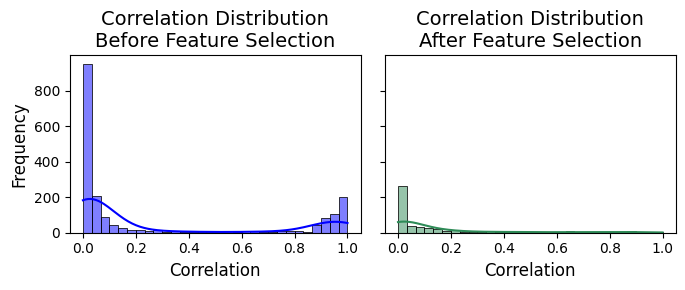

In [ ]:
# visualizations
import seaborn as sns
import matplotlib.pyplot as plt
#used to count features for visualization
from collections import Counter

#create list of features before and after
all_features = [col for col in t_train_df.columns if col not in excluded_columns]
sel_features = [col for col in t_train_out.columns if col not in excluded_columns]

# calculate corelation matrices for before and after features
corr_matrix_all = t_train_df[all_features].corr().abs()
corr_matrix_sel = t_train_out[sel_features].corr().abs()

# avoid counting duplicate correlation values by excluding the diagnol and below in matrix
#create mask for upper triangle of matrix
upper_tri_mask_all = np.triu(np.ones(corr_matrix_all.shape), k=1).astype(bool)
# apply mask to all features
upper_all = corr_matrix_all.where(upper_tri_mask_all)
#flatten
upper_all = upper_all.stack()

#create a mask for the upper triangle of selcted feature matrix
upper_tri_mask_sel = np.triu(np.ones(corr_matrix_sel.shape), k=1).astype(bool)

#apply the mask to selected features
upper_sel = corr_matrix_sel.where(upper_tri_mask_sel)
#flatten
upper_sel = upper_sel.stack()

#plot side by side histograms
fig, axs = plt.subplots(1, 2, figsize=(7, 3), sharey=True)

#plot histogram for all features before feature selction
sns.histplot(upper_all, bins=30, kde=True, ax=axs[0], color='blue')
axs[0].set_title("Correlation Distribution\nBefore Feature Selection", fontsize=14)
axs[0].set_xlabel("Correlation", fontsize=12)
axs[0].set_ylabel("Frequency", fontsize = 12)

#plot histogram for selected features
sns.histplot(upper_sel, bins=30, kde=True, ax=axs[1], color='seagreen')
axs[1].set_title("Correlation Distribution\nAfter Feature Selection", fontsize =14)
axs[1].set_xlabel("Correlation", fontsize=12)
axs[1].set_ylabel("Frequency", fontsize=12)

#adjust spacing between graphs
plt.tight_layout()
